In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import h5py
from keras.datasets import cifar10
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from sklearn import metrics
from skimage.measure import compare_ssim
from scipy.misc import toimage
from sklearn.preprocessing import *

import os
import random
import time
from skimage import io, exposure, feature, color, transform
import matplotlib
import matplotlib.pyplot as plt
import glob

import scipy.signal as sig
import operator
import math

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using Theano backend.
Using gpu device 1: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [2]:
# parameters for sliding window, and window function (Hann)
STEP_SIZE = 480
OVERLAP_SIZE = 32
WINDOW_SIZE = STEP_SIZE + OVERLAP_SIZE
OVERLAP_FUNC = sig.hann(OVERLAP_SIZE * 2)

# directory that contains TIMIT files
TIMIT_DIR = "/home/sri/Desktop/timit"

# directory that contains .wav files to process
NUM_EPOCHS = 1
BATCH_SIZE = 64

# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# sample rate of input file (used in MFCC calculation)
SAMPLE_RATE = 16000

In [3]:
from load_TIMIT import *
from windowingFunctions import *
from utility import *

In [4]:
# read in 100 WAVs from TIMIT training set
rawWaveforms = load_TIMIT_train(TIMIT_DIR, 1000)

Reading in .wav files...


In [5]:
# waveform preprocessing
def preprocessWaveform(waveform):
    # scale window between -1 and 1
    mn = np.min(waveform)
    mx = np.max(waveform)
    maxabs = np.maximum(np.abs(mn), np.abs(mx))
        
    return np.copy(waveform) / maxabs, (maxabs,)
   
def unpreprocessWaveform(waveform, params):
    return np.copy(waveform) * params[0]



# window preprocessing
def preprocessWindows(windows):
    return windows, ()

def unpreprocessWindows(windows, params):
    return windows

In [6]:
# waveform preprocessing
processedWaveforms = np.copy(rawWaveforms)

# we maximize the volume of every waveform
for i in xrange(0, len(processedWaveforms)):
    if (i == 0):
        print np.min(processedWaveforms[i])
        print np.max(processedWaveforms[i])
    processedWaveforms[i], wc = preprocessWaveform(rawWaveforms[i])
    if (i == 0):
        print processedWaveforms[i].shape
        print np.min(processedWaveforms[i])
        print np.max(processedWaveforms[i])
        print wc

-6672.0
8744.0
(47616,)
-0.763037511436
1.0
(8744.0,)


In [7]:
print rawWaveforms[0]

processedWave, wparams = preprocessWaveform(rawWaveforms[0])
print processedWave
print processedWave * wparams[0]
print ""

windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)

# first, write desired reconstruction
transformed, tparams = preprocessWindows(windows)

desired = unpreprocessWindows(transformed, tparams)
print np.sum(desired - windows)

desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
print np.sum(desired[:47616] - processedWave)

desired = unpreprocessWaveform(desired, wparams)
print np.sum(desired[:47616] - rawWaveforms[0])

print desired
print np.sum(desired.astype(np.int16)[:47616] - rawWaveforms[0].astype(np.int16))

[ -5.   3.   3. ..., -18. -19. -17.]
[-0.00057182  0.00034309  0.00034309 ..., -0.00205855 -0.00217292
 -0.00194419]
[ -5.   3.   3. ..., -18. -19. -17.]

0.0
0.0853271408162
746.09852761
[-5.  3.  3. ...,  0.  0.  0.]
784


In [8]:
# extract windows
rawWindows = extractWindowsMultiple(processedWaveforms, STEP_SIZE, OVERLAP_SIZE,
                                    collapse = True)

# randomly shuffle data
if (RANDOM_SHUFFLE):
    rawWindows = np.random.permutation(rawWindows)

print "Raw windows shape: ", rawWindows.shape
print "Max: ", np.amax(rawWindows)
print "Min: ", np.amin(rawWindows)

Raw windows shape:  (101135, 512)
Max:  1.0
Min:  -1.0


In [9]:
# data augmentation goes here, at some point
augWindows = np.copy(rawWindows)

print "Aug windows shape: ", augWindows.shape

Aug windows shape:  (101135, 512)


In [10]:
processedWindows, pwParams = preprocessWindows(augWindows)

In [11]:
# reshape into vector form
processedWindows = np.reshape(processedWindows, (processedWindows.shape[0], WINDOW_SIZE, 1))

In [12]:
print processedWindows.shape

print np.mean(processedWindows, axis=None)
print np.std(processedWindows, axis=None)
print np.min(processedWindows, axis = None)
print np.max(processedWindows, axis = None)

(101135, 512, 1)
9.77603e-07
0.099766
-1.0
1.0


In [13]:
class PhaseShiftDown1D(Layer):
    """ PhaseShiftDown1D
    Takes vector of size: B x nS x F
    And returns vector: B x S x nF
    """
    def __init__(self, n, **kwargs):
        super(PhaseShiftDown1D, self).__init__(**kwargs)
        self.n = n
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        r = T.reshape(x, (x.shape[0], x.shape[1] / self.n, self.n, x.shape[2]))
        r = T.transpose(r, (0, 1, 3, 2))
        r = T.reshape(r, (x.shape[0], x.shape[1] / self.n, x.shape[2] * self.n))
        return r

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1] / self.n, input_shape[2] * self.n)
    
    def get_config(self):
        config = {'n' : self.n}
        base_config = super(PhaseShiftDown1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
class PhaseShiftUp1D(Layer):
    """ PhaseShiftUp1D
    Takes vector of size: B x S x nF
    And returns vector: B x nS x F
    """
    def __init__(self, n, **kwargs):
        super(PhaseShiftUp1D, self).__init__(**kwargs)
        self.n = n
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        r = T.reshape(x, (x.shape[0], x.shape[1], x.shape[2] / self.n, self.n))
        r = T.transpose(r, (0, 1, 3, 2))
        r = T.reshape(r, (x.shape[0], x.shape[1] * self.n, x.shape[2] / self.n))
        return r

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1] * self.n, input_shape[2] / self.n)
    
    def get_config(self):
        config = {'n' : self.n}
        base_config = super(PhaseShiftUp1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
# quantizes [-1.0, 1.0] into a certain number of uniform bins
class UniformQuantizer(Layer):
    def __init__(self, nbins, noise_in_train = True, **kwargs):
        self.supports_masking = True
        self.nbins = nbins
        self.noise_in_train = noise_in_train
        self.uses_learning_phase = True
        super(UniformQuantizer, self).__init__(**kwargs)

    def call(self, x, mask=None):
        # during training, add uniform noise the width of one bin
        noise_x = x + K.random_uniform(shape = K.shape(x),
                                       low = -(1.0 / (self.nbins - 1)),
                                       high = 1.0 / (self.nbins - 1))
        
        # during testing, actually quantize the thing
        qnt_x = (x + 1.0) / 2.0
        qnt_x = K.round(qnt_x * float(self.nbins - 1)) / float(self.nbins - 1)
        qnt_x = (qnt_x * 2.0) - 1.0
        
        if (self.noise_in_train):
            return K.in_train_phase(noise_x, qnt_x)
        else:
            return K.in_train_phase(x, qnt_x)

    def get_config(self):
        config = {'nbins': self.nbins}
        base_config = super(UniformQuantizer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [16]:
class SelectMax(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, n):
        super(SelectMax, self).__init__()
        self.n = n
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        zero_idxs = np.argsort(np.abs(x), axis = -1)[:, :-self.n]
        col_idxs = np.arange(x.shape[0])[:, None]
        out = np.copy(x)
        x[col_idxs, zero_idxs] = 0
        z[0] = x
    
    def grad(self, input, output_gradients):
        x, = input
        g, = output_gradients
        
        zero_idxs = T.argsort(T.abs_(x), axis = -1)[:, :-self.n, None]
        
        idnt = T.eye(x.shape[-1]) * 0.99
        
        grad_mult = idnt[zero_idxs]
        grad_mult = T.sum(grad_mult, axis = -3)[:, 0, :]
        grad_mult = 1.0 - grad_mult
        
        grad_mult = grad_mult + 0.01
        
        out_grad = g * grad_mult
        
        return [out_grad]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [17]:
# only works with theano dawg
class OrthogonalDense(Layer):
    def __init__(self, tied_to = None, has_bias = False, **kwargs):
        super(OrthogonalDense, self).__init__(**kwargs)
        self.tied_to = tied_to
        self.has_bias = has_bias

    def build(self, input_shape):
        input_dim = input_shape[1]
        
        self.n = input_dim
        
        # we store a full matrix, but use it as a skew-symmetric one
        if (self.tied_to is None):
            self.W = np.random.uniform(-0.001, 0.001, (self.n, self.n))
            self.W = K.variable(self.W)
            self.trainable_weights = [self.W]
            
            if (self.has_bias):
                self.b = K.variable(np.zeros((self.n,)))
                self.trainable_weights = [self.W, self.b]
    
    def produce_unitary(self):
        # produce skew-symmetric matrix from W
        upper = T.triu(self.W, k = 1)
        skew = upper - K.transpose(upper)
        
        # compute approximate matrix exponential
        a = K.eye(self.n)
        unitary = K.zeros((self.n, self.n))
        
        for i in xrange(0, 11):
            c = 1.0 / math.factorial(i)

            unitary += c * a
            a = T.dot(a, skew)
        
        return unitary
        
    def call(self, x, mask=None):
        if (self.tied_to is None):
            unitary = self.produce_unitary()
            out = K.dot(x, unitary)
            return ((out + self.b) if self.has_bias else out)
        else:
            #unitary = T.nlinalg.matrix_inverse(self.tied_to.produce_unitary())
            unitary = K.transpose(self.tied_to.produce_unitary())
            inp = (x - self.tied_to.b) if self.tied_to.has_bias else x
            return K.dot(inp, unitary)

In [18]:
class CodeRound(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, nbins):
        self.nbins = nbins
        super(CodeRound, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        s = (x + 1.0) / 2.0
        s = np.round(s * float(self.nbins - 1)) / float(self.nbins - 1)
        s = (s * 2.0) - 1.0
        
        z[0] = s
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        x, = input
        g, = output_gradients
        return [g]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [19]:
# only works with theano dawg
class TiedDense(Layer):
    def __init__(self, has_bias = False, tied_to = None, inverse = False, **kwargs):
        super(TiedDense, self).__init__(**kwargs)
        self.has_bias = has_bias
        self.tied_to = tied_to
        self.inverse = inverse

    def build(self, input_shape):
        input_dim = input_shape[1]
        
        self.n = input_dim
        
        # we store a full matrix, but use it as a skew-symmetric one
        if (self.tied_to is None):
            self.W = np.eye(self.n) + np.random.uniform(-0.001, 0.001, (self.n, self.n))
            self.W = K.variable(self.W)
            
            if (self.has_bias):
                self.b = np.random.uniform(-0.001, 0.001, (self.n,))
                self.b = K.variable(self.b)
                self.trainable_weights = [self.W, self.b]     
            else:
                self.b = np.zeros((self.n,))
                self.b = K.variable(self.b)
                self.trainable_weights = [self.W]
        
    def call(self, x, mask=None):
        if (self.tied_to is None):
            return K.dot(x + self.b, self.W) + self.b
        else:
            if (self.inverse):
                w = T.nlinalg.matrix_inverse(self.tied_to.W)
            else:
                w = K.transpose(self.tied_to.W)
            return K.dot(x - self.tied_to.b, w)

In [20]:
class VariableSelectMax(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, n):
        super(VariableSelectMax, self).__init__()
        self.n = n
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        zero_idxs = np.argsort(np.abs(x), axis = -1)[:, :-K.get_value(self.n)]
        col_idxs = np.arange(x.shape[0])[:, None]
        out = np.copy(x)
        x[col_idxs, zero_idxs] = 0
        z[0] = x
    
    def grad(self, input, output_gradients):
        x, = input
        g, = output_gradients
        
        zero_idxs = T.argsort(T.abs_(x), axis = -1)[:, :-K.get_value(self.n), None]
        
        idnt = T.eye(x.shape[-1]) * 0.99
        
        grad_mult = idnt[zero_idxs]
        grad_mult = T.sum(grad_mult, axis = -3)[:, 0, :]
        grad_mult = 1.0 - grad_mult
        
        grad_mult = grad_mult + 0.01
        
        out_grad = g * grad_mult
        
        return [out_grad]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [21]:
NUM_MEL_BINS = 20

def freqToMel(freq):
    return 1127.01048 * math.log(1 + freq / 700.0)

def melToFreq(mel):
    return 700 * (math.exp(mel / 1127.01048) - 1)

def generateMelWindows():
    minHz = 0
    maxHz = SAMPLE_RATE / 2
    numDCTBins = WINDOW_SIZE
    
    minMel = freqToMel(minHz)
    maxMel = freqToMel(maxHz)

    # evenly spaced bins between minMel and maxMel
    melRange = np.arange(0, NUM_MEL_BINS + 1).astype('float32')
    melIdxs = melRange * (maxMel - minMel) / (NUM_MEL_BINS) + minMel
    
    # convert back to freq / dct domain
    for i in xrange(0, NUM_MEL_BINS + 1):
        melIdxs[i] = melToFreq(melIdxs[i])
        melIdxs[i] = math.floor(numDCTBins * melIdxs[i] / maxHz)
    melIdxs = melIdxs.astype(np.int32)
    
    return melIdxs

melIdxs = generateMelWindows()
for i in xrange(0, NUM_MEL_BINS):
    print melIdxs[i], "to", melIdxs[i + 1]

0 to 6
6 to 12
12 to 20
20 to 29
29 to 39
39 to 50
50 to 63
63 to 77
77 to 94
94 to 113
113 to 134
134 to 158
158 to 185
185 to 216
216 to 251
251 to 291
291 to 336
336 to 387
387 to 446
446 to 512


In [22]:
s = K.variable([[1, 2, 3, 4], [5, 6, 7, 8]])

K.mean(s, axis = -1).eval()

array([ 2.5,  6.5], dtype=float32)

In [24]:
from keras.activations import softmax, sigmoid
from scipy.fftpack import dct, idct

# lambda to compute MSE between 2 vectors
def mse_lambda(vects):
    x, y = vects
    return K.mean(K.square(x - y))

# freeze weights for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

# we generate a new optimizer of the same kind for every model
# we train
def opti():
    return RMSprop()

input_dim = (WINDOW_SIZE, 1)
input_size = np.prod(input_dim)
bottleneck_size = 128


tau = K.variable(1.0, name = 'temperature')
anneal_rate = 0.02
min_temperature = 0.1

BNORM = False

dct_mat = dct(np.eye(bottleneck_size), norm = 'ortho')
inv_dct_mat = idct(np.eye(bottleneck_size), norm = 'ortho')

# construct Haar wavelet matrices
h2 = 1.0/math.sqrt(2.0) * np.array([[1, 1], [1, -1]])
prev = h2
for i in xrange(0, 8):
    a = np.kron(prev, [1, 1])
    d = np.kron(np.eye(prev.shape[0]), [1, -1])
    prev = 1.0/math.sqrt(2.0) * np.vstack((a, d))
haar_mat = np.copy(prev)
inv_haar_mat = np.linalg.inv(haar_mat)



    

    
    
    



def activation():
    return LeakyReLU(0.3)#ThresholdedReLU()#Activation('tanh')
autoenc_init = 'uniform'

def residual_block(output_dim = 64, filt_size = 5, conv = True):
    def f(input):
        #bn1 = BatchNormalization()(input)
        #act1 = activation()(bn1)
        conv1 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = autoenc_init, activation = 'linear',
                          bias = True)(input)
        if (BNORM): conv1 = BatchNormalization()(conv1)
        act1 = activation()(conv1)
        conv2 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = autoenc_init, activation = 'linear',
                          bias = True)(act1)
        if (BNORM): conv2 = BatchNormalization()(conv2)
        
        #'''
        residual = conv2
        if (conv):
            #shortcut = Convolution1D(output_dim, 1, border_mode = 'same',
            #                         init = autoenc_init, activation = 'linear',
            #                         bias = False)(input)
            shortcut = Lambda(lambda x : K.repeat_elements(x, output_dim, axis = -1),
                              output_shape = (lambda s : (s[0], s[1], output_dim)))(input)
        else:
            shortcut = input
        
        m = merge([shortcut, residual], mode = 'sum')
        return m
    
    return f


# total # layers: NUM_RES_BLOCKS * 4
NUM_RES_BLOCKS = 8
NBINS = 64
nselect = K.variable(511, dtype = 'int32')
NCHAN = 32
TIMES_DOWNSAMPLE = 2

# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):
    # convolutional layers have weight matrices of shape:
    #     (filter_length, 1, input_dim, nb_filter)
    # and biases of size (nb_filter,)
    
    # weights for an "identity convolution" (which just
    # replicates the input across all channels)
    #     filter of length 5, going from 1 channel to NCHAN
    def identity_conv():
        weights = np.zeros((5, 1, 1, NCHAN))
        weights[3] = np.ones((1, 1, NCHAN))
        weights += np.random.uniform(-0.01, 0.01, weights.shape)
        biases = np.zeros((NCHAN,))
        return [weights, biases]
    
    
    # weights for an "average convolution" (which just
    # replicates the input across all channels)
    #     filter of length 1, going from NCHAN channels to 1
    def average_conv():
        weights = np.ones((1, 1, NCHAN, 1)) / float(NCHAN)
        weights += np.random.uniform(-0.01, 0.01, weights.shape)
        biases = np.zeros((1,))
        return [weights, biases]
    
    
    # weights for a "phase shift up" convolution (by default,
    # performs an upsample)
    #     filter of length 5, going from NCHAN to NCHAN * 2
    def shift_up_conv():
        weights = np.zeros((5, 1, NCHAN, NCHAN * 2))
        weights[3, 0] = np.repeat(np.eye(NCHAN), 2, axis = 1)
        weights += np.random.uniform(-0.01, 0.01, weights.shape)
        biases = np.zeros((NCHAN * 2,))
        return [weights, biases]
    
    
    # weights for a "phase shift down" convolution (by default,
    # performs an average)
    #     filter of length 5, going from NCHAN to NCHAN / 2
    def shift_down_conv():
        weights = np.zeros((5, 1, NCHAN, NCHAN / 2))
        weights[3, 0] = np.repeat(np.eye(NCHAN / 2), 2, axis = 0) / 2.0
        weights += np.random.uniform(-0.01, 0.01, weights.shape)
        biases = np.zeros((NCHAN / 2,))
        return [weights, biases]
    
    
    
    
    
    
    enc_input = Input(shape = dim)
    enc = Reshape(dim, input_shape = dim)(enc_input)
    
    # increase number of channels via convolution
    enc = Convolution1D(NCHAN, 5, border_mode = 'same',
                          init = 'uniform', activation = 'linear',
                          weights = identity_conv(),
                          bias = True)(enc)
    enc = activation()(enc)
    
    # downsample
    for i in xrange(0, TIMES_DOWNSAMPLE):
        enc = Convolution1D(NCHAN / 2, 5, border_mode = 'same',
                              init = 'uniform', activation = 'linear',
                              weights = shift_down_conv(),
                              bias = True)(enc)
        enc = PhaseShiftDown1D(2)(enc)
        enc = activation()(enc)
    
    # residual blocks
    for i in xrange(0, NUM_RES_BLOCKS):
        enc = residual_block(NCHAN, 5, False)(enc)
    
    # convolution across feature maps
    enc = Convolution1D(1, 1, border_mode = 'same',
                              init = autoenc_init,
                              bias = True,
                              weights = average_conv())(enc)
    enc = Activation('tanh')(enc)
    enc = Reshape((bottleneck_size,))(enc)
    
    enc = Model(input = enc_input, output = enc)
    
    
    
    
    
    dec_input = Input(shape = (bottleneck_size,))
    dec = Reshape((bottleneck_size,), input_shape = (bottleneck_size,))(dec_input)
    
    # increase number of channels via convolution
    dec = Reshape((bottleneck_size, 1,))(dec)
    dec = Convolution1D(NCHAN, 5, border_mode = 'same',
                          init = 'uniform', activation = 'linear',
                          weights = identity_conv(),
                          bias = True)(dec)
    dec = activation()(dec)

    # residual blocks
    for i in xrange(0, NUM_RES_BLOCKS):
        dec = residual_block(NCHAN, 5, False)(dec)    
    
    # upsample
    for i in xrange(0, TIMES_DOWNSAMPLE):
        dec = Convolution1D(NCHAN * 2, 5, border_mode = 'same',
                              init = 'uniform', activation = 'linear',
                              weights = shift_up_conv(),
                              bias = True)(dec)
        dec = PhaseShiftUp1D(2)(dec)
        dec = activation()(dec)
    
    # convolution across feature maps
    dec = Convolution1D(1, 1, border_mode = 'same',
                              activation = 'linear',
                              bias = True,
                              weights = average_conv())(dec)
    dec = Activation('tanh')(dec)
    
    dec = Model(input = dec_input, output = dec)
    
    return enc, dec

# ---------------------------------------------------------------------------
# discriminator: tries to differentiate between original and reconstructed samples
# ---------------------------------------------------------------------------
def discriminator_structure(dim):
    dsc = Sequential()
    
    #dsc.add(GaussianNoise(0.05, input_shape = dim))
    
    dsc.add(Convolution1D(16, 5, border_mode='same',
                                    init = 'he_uniform',
                                    input_shape = dim, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    if (BNORM): dsc.add(BatchNormalization())
    
    dsc.add(Convolution1D(16, 5, border_mode='same', input_shape = dim,
                                    init = 'he_uniform',
                                    subsample_length = 1, activation = 'linear'))
    dsc.add(AveragePooling1D(2))
    dsc.add(LeakyReLU(0.3))
    if (BNORM): dsc.add(BatchNormalization())
    
    dsc.add(Convolution1D(32, 5, border_mode='same',
                                    init = 'he_uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    if (BNORM): dsc.add(BatchNormalization())

    dsc.add(Convolution1D(32, 5, border_mode='same',
                                    init = 'he_uniform',
                                    subsample_length = 1, activation = 'linear'))
    dsc.add(AveragePooling1D(2))
    dsc.add(LeakyReLU(0.3))
    if (BNORM): dsc.add(BatchNormalization())
    
    dsc.add(Convolution1D(64, 5, border_mode='same',
                                    init = 'he_uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    if (BNORM): dsc.add(BatchNormalization())
    
    dsc.add(Convolution1D(64, 5, border_mode='same',
                                    init = 'he_uniform',
                                    subsample_length = 1, activation = 'linear'))
    dsc.add(AveragePooling1D(2))
    dsc.add(LeakyReLU(0.3))
    if (BNORM): dsc.add(BatchNormalization())
    
    dsc.add(GlobalAveragePooling1D())
    dsc.add(Dense(1, activation = 'sigmoid', init = 'he_uniform'))
    
    return dsc


# construct autoencoder to be used in adversarial training (AAC - Adversarial AutoenCoder)
# uhhhh... whoops i screwed up the acronym
aac_input = Input(shape = input_dim)
aac_enc, aac_dec = autoencoder_structure(input_dim)
aac_embedding = aac_enc(aac_input)
aac_reconstructed = aac_dec(aac_embedding)

aac_autoencoder = Model(input = [aac_input], output = [aac_reconstructed])
aac_autoencoder.compile(loss = 'mean_squared_error', optimizer = opti())



# construct discriminator: regular
regdsc_input_dim = (WINDOW_SIZE, 1)
regdsc_input = Input(shape = input_dim)
regdsc_struct = discriminator_structure(regdsc_input_dim)

regdsc_label = regdsc_struct(regdsc_input)
aac_reg_label = regdsc_struct(aac_reconstructed)
#aac_decode_label = regdsc_struct(aac_decode_recons)




def code_ternary_constraint(placeholder, code):
    entropy = K.minimum(K.abs(-1.0 - code), K.minimum(K.abs(code), K.abs(1.0 - code)))
    entropy = K.clip(entropy, 0.01, 1.0)
    entropy = K.sqrt(entropy)
    return K.mean(entropy, axis = -1)


def code_binary_constraint(placeholder, code):
    scaled = (code + 1.0) / 2.0
    scaled = K.clip(scaled, 0.001, 0.999)
    entropy = -(scaled * K.log(scaled) + (1.0 - scaled) * K.log(1.0 - scaled))
    return K.mean(entropy, axis = -1)

def code_balance_constraint(placeholder, code):
    # code ranges from 0 to 1
    # we try to maximize the approx. variance of it
    var = K.var(code, axis = -1) + 0.001
    return (1.0 / var)
    #return K.abs(K.mean(code, axis = -1))

clip_point = 0.0001
k = 0.5
def code_sparsity_constraint(placeholder, code):
    clipped = K.clip(K.abs(code), clip_point, 1.0)
    lk_norm = K.pow(clipped, k)
    return K.mean(lk_norm, axis = -1)




dct_mat = K.variable(dct(np.eye(WINDOW_SIZE), norm = 'ortho'))

def apply_dct(batch):
    reshaped = batch.reshape((1, batch.shape[0], batch.shape[1]))
    result = T.tensordot(dct_mat, reshaped, [[0], [2]])
    result = result.reshape((result.shape[0], result.shape[2])).T
    result = result.reshape((result.shape[0], result.shape[1]))
    return result


def mel_dct_loss(y_true, y_pred):
    dct_true = apply_dct(y_true)
    dct_pred = apply_dct(y_pred)
    
    loss = None
    for i in xrange(0, NUM_MEL_BINS):
        start = melIdxs[i]
        end = melIdxs[i + 1]
        
        sq = K.square(dct_pred[:, start:end] - dct_true[:, start:end])
        mse = K.mean(sq, axis = -1)
        mse = K.clip(mse, 0.000001, 10000.0)
        if (loss is None):
            loss = K.sqrt(mse)
        else:
            loss += K.sqrt(mse)
    
    return loss
    

def compaction_loss(placeholder, code):
    norm = K.sqrt(K.sum(K.square(code), axis = -1))
    
    #mx_norm = K.sqrt(K.max(K.abs(code), axis = -1))
    top = T.sort(K.square(code))[:, -16:]
    mx_norm = K.sqrt(K.sum(top, axis = -1))
    ratio = mx_norm / norm
    
    return -K.log(K.clip(ratio, 0.0001, 0.9999))

def rmse(y_true, y_pred):
    mse = K.mean(K.square(y_pred - y_true), axis = -1)
    mse = K.clip(mse, 0.000001, 10000.0)
    return K.sqrt(mse)


# compile model
#loss_weights = [500.0, 25.0]
loss_weights = [40.0, 10.0, 1.0]
loss_functions = [rmse, mel_dct_loss, 'binary_crossentropy']
n_discrim = 1
n_code = 0
lmult = len(loss_weights) - n_discrim - n_code


make_trainable(aac_autoencoder, False)

aac_discrim_reg = Model(input = [regdsc_input], output = [regdsc_label])
aac_discrim_reg.compile(loss = ['binary_crossentropy'], optimizer = opti())
aac_discrim_reg.summary()

aac_autoencoder.summary()

make_trainable(aac_discrim_reg, False)
make_trainable(aac_autoencoder, True)
model = Model(input = [aac_input], output = [aac_reconstructed, aac_reconstructed] + \
                                            [aac_reg_label] * n_discrim + \
                                            [aac_embedding] * n_code)
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = opti())
model.summary()



X_train = np.copy(processedWindows)
ntrain = X_train.shape[0]
discrim_epoch = False


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 1)             40945       input_6[0][0]                    
Total params: 40,945
Trainable params: 40,497
Non-trainable params: 448
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 512, 1)        0                                            
___________________

In [25]:
def test_discriminator(discriminator, autoencoder, X, y, verbose = True):
    # verify discriminator was trained properly
    y_hat = discriminator.predict(X)
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    n_total = y.shape[0]
    n_correct = np.sum(np.ravel(y_hat) == y)

    acc = n_correct * 100.0 / n_total
    if (verbose):
        print "Discriminator accuracy: %0.02f pct (%d of %d) right"%(acc, n_correct, n_total)
    return acc

In [26]:
def autoencoderTest(waveFilename, prefix, autoencoder, verbose = True):
    [rate, data] = sciwav.read(waveFilename)
    data = data.astype(np.float32)
    processedWave, wparams = preprocessWaveform(data)
    windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
    

    # first, write desired reconstruction
    transformed, tparams = preprocessWindows(windows)
    if (verbose):
        print transformed.shape
    
    desired = unpreprocessWindows(transformed, tparams)
    desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocessWaveform(desired, wparams)
    desired = np.clip(desired, -32767, 32767)
    #sciwav.write(prefix + "_res_desired.wav", rate, desired.astype(np.int16))
    
    # then, run NN on transformed windows
    transformed, tparams = preprocessWindows(windows)
    
    transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
    autoencOutput = autoencoder.predict(transformed, batch_size = BATCH_SIZE, verbose = (1 if verbose else 0))
    if (verbose):
        print autoencOutput.shape
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    
    if (verbose):
        print autoencOutput.shape
    recons = unpreprocessWindows(autoencOutput, tparams)
    recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocessWaveform(recons, wparams)
    recons = np.clip(recons, -32767, 32767)
    
    sciwav.write(prefix + "_output.wav", rate, recons.astype(np.int16))
    
    metrics = [
        np.max(desired),
        np.min(desired),
        np.max(recons),
        np.min(recons),
        mse(recons, desired),
        avgErr(recons, desired)
    ]
    
    if (verbose):
        print "Max/min desired:", metrics[0], metrics[1]
        print "Max/min recons: ", metrics[2], metrics[3]
        print waveFilename, " mse: ", metrics[4]
        print waveFilename, " avg err: ", metrics[5]
        
    return metrics

In [27]:
# interleave numpy arrays of the same size along the first axis
def interleave(arr):    
    num = len(arr)
    
    r = np.empty(arr[0].shape)
    r = np.repeat(r, num, axis = 0)
    
    for i in xrange(0, num):
        r[i::num] = arr[i]

    return r

In [28]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 50

lead = "    "
d_loss = 0.0
a_losses = []
d_acc = 0.0
discrim_train_y = np.concatenate((np.ones(ntrain), np.zeros(ntrain)))

for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["autoencoder not training"]
        d_loss = "discriminator not training"
        
        # train autoencoder, if discriminator accuracy is greater than 70%
        if (discrim_epoch or epoch > 0):
            make_trainable(aac_autoencoder, True)
            make_trainable(aac_discrim_reg, False)
            discrim_epoch = True
            
            a_y = [batch] * lmult + \
                  [np.ones(nbatch)] * n_discrim + \
                  [np.zeros((nbatch, bottleneck_size))] * n_code
            a_losses = model.train_on_batch(batch, a_y)
        
        if (n_discrim > 0):
            #code = aac_enc.predict(batch)
            #code_binarized = np.sign(code)
            #c_losses = decoder_model.train_on_batch(code_binarized, [batch, np.ones(nbatch)])

            # train discriminator(s) on what the autoencoder now generates
            #generated = aac_dec.predict(code)
            #generated_binarized = aac_dec.predict(code_binarized)
            #discrim_batch_X = interleave([batch, generated, generated_binarized])
            #discrim_batch_y = interleave([np.ones(nbatch), np.zeros(nbatch), np.zeros(nbatch)])
            generated = aac_autoencoder.predict(batch)
            discrim_batch_X = interleave([batch, generated])
            discrim_batch_y = interleave([np.ones(nbatch), np.zeros(nbatch)])

            make_trainable(aac_autoencoder, False)
            make_trainable(aac_discrim_reg, True)
            d_loss = aac_discrim_reg.train_on_batch(discrim_batch_X, discrim_batch_y)
            
            if ((not discrim_epoch) and epoch == 0 and d_loss < 0.2):
                print ""
                print lead + "Terminating epoch early (don't wanna overfit!)"
                discrim_epoch = True
                break
        else:
            d_loss = -1
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(d_loss) + " "
            print printStr,
            
            #'''
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for i in xrange(0, len(loss_weights)):
                    loss_arr[i + 1] *= loss_weights[i]
                print loss_arr,
            
            #loss_arr = np.asarray(c_losses)
            #print loss_arr,
            #'''
            
            '''
            for l in [a_losses, c_losses]:
            #for l in [a_losses]:
                loss_arr = np.asarray(l)
                print loss_arr,

                if (len(loss_arr) > 1):
                    for i in xrange(0, len(loss_weights)):
                        loss_arr[i + 1] *= loss_weights[i]
                    print loss_arr,
            '''
            
            print K.get_value(tau),
            K.set_value(tau, np.max([K.get_value(tau) * (1 - anneal_rate), min_temperature]))
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"   
    
    # ---------------------------------------------------------
    # evaluate discriminator on random samples every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    if (n_discrim > 0):
        NUM = 200
        rows = np.random.randint(X_train.shape[0], size = NUM)
        generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
        d_X = np.concatenate((X_train[rows, :], generated))
        d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
        d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                                   d_X, d_y, verbose = False)

        print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"
        elapsed = time.time() - startTime
        print lead + "Total time for evaluation: " + str(elapsed) + "s"
    else:
        print lead + "No discriminator"
    
    
    # ---------------------------------------------------------
    # generate code histogram from said random samples
    # ---------------------------------------------------------
    NUM = 200
    rows = np.random.randint(X_train.shape[0], size = NUM)
    code = aac_enc.predict(X_train[rows, :], verbose = 0)
    
    print lead + "----------------"
    print lead + "Code histogram:"
    scalars = code.flatten()
    
    b = np.linspace(-1.0, 1.0, NBINS + 1)
    hist = np.histogram(scalars, bins = b)
    sample_hist_probs = hist[0].astype('float32')
    sample_hist_bins = hist[1].astype('float32')
    sample_hist_probs /= np.sum(sample_hist_probs)

    entropy = 0
    for i in sample_hist_probs:
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    
    zero_prob = sample_hist_probs[NBINS / 2]
    zero_prob = np.clip(zero_prob, 0.001, 0.999)
    mask_entropy = -(zero_prob * math.log(zero_prob, 2) + (1.0 - zero_prob) * math.log(1.0 - zero_prob, 2))
    
    print "       Entropy:", entropy
    print "       Zero prob:", sample_hist_probs[NBINS / 2]
    print "       Mask entropy:", mask_entropy
    
    nnz = 0.0
    for i in xrange(0, code.shape[0]):
        r = np.round(code[i] * 1000.0) / 1000.0
        nnz += np.count_nonzero(r)
    nnz /= code.shape[0]
    print "       Avg # nonzero elts:", nnz
    
    '''
    sample_hist_width = 1 * (sample_hist_bins[1] - sample_hist_bins[0])
    sample_hist_centers = (sample_hist_bins[:-1] + sample_hist_bins[1:]) / 2
    plt.figure()
    plt.bar(sample_hist_centers, nonzero_probs, align='center', width=sample_hist_width)
    plt.show()
    '''
    
    '''
    for i in xrange(0, 3):
        print "       Within", i,  "bin(s):",
        tot = 0
        for j in xrange(0, i + 1):
            tot += sample_hist_probs[j]
            tot += sample_hist_probs[-(j+1)]
        print tot
        
    sample_hist_width = 1 * (sample_hist_bins[1] - sample_hist_bins[0])
    sample_hist_centers = (sample_hist_bins[:-1] + sample_hist_bins[1:]) / 2
    plt.figure()
    plt.bar(sample_hist_centers, sample_hist_probs, align='center', width=sample_hist_width)
    plt.show()
    '''
    
    # ---------------------------------------------------------
    # evaluate autoencoder on real data every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    
    print lead + "Evaluating autoencoder..."
    metrics = autoencoderTest("./SA1.WAV", "SA1_res_reg_train_epoch" + str(epoch+1), aac_autoencoder, verbose = False)
    
    print lead + "Max/min desired:", metrics[0], metrics[1]
    print lead + "Max/min recons: ", metrics[2], metrics[3]
    print lead + "MSE:     ", metrics[4]
    print lead + "Avg err: ", metrics[5]
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    # --------------------------------------------------------
    # update loss weights every epoch
    # ---------------------------------------------------------
    if (len(loss_weights) > 1 and n_code > 0 and epoch > 0):
        w_idx = len(loss_weights) - 1
        
        limit = 30.0
        if (loss_weights[w_idx] < limit):
            loss_weights[w_idx] += 0.25
            if (loss_weights[w_idx] > limit): loss_weights[w_idx] = limit
            
            make_trainable(aac_discrim_reg, True)
            make_trainable(aac_autoencoder, True)
            model.compile(loss = loss_functions,
                          loss_weights = loss_weights,
                          optimizer = opti())
            print lead + "Updated code constraint weight:", loss_weights[w_idx]
        else:
            loss_weights[w_idx] = limit
            print lead + "Didn't update code constraint weight:", loss_weights[w_idx]
    #'''
    
    if (epoch > 0):
        old_n = K.get_value(nselect)
        if (old_n > 16):
            new_n = int(float(old_n) * 0.95)
            K.set_value(nselect, new_n)
            print lead + "Updated SelectMax from", old_n, "to", K.get_value(nselect)
        else:
            K.set_value(nselect, 16)
            print lead + "Didn't update SelectMax from", old_n
    
    print ""

Epoch 1:
    0: 0.717552006245  ['autoencoder not training'] 1.0 
    Terminating epoch early (don't wanna overfit!)

    Total time for epoch: 39.6158280373s
    ----------------
    Evaluated the discriminator: 50.0% d_acc
    Total time for evaluation: 2.901004076s
    ----------------
    Code histogram:
       Entropy: 1.89050873601
       Zero prob: 0.562969
       Mask entropy: 0.98852881642
       Avg # nonzero elts: 96.865
    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  2726.73 -0.0546441
    MSE:      275603.0
    Avg err:  280.36
    Total time for evaluation: 0.170010089874s

Epoch 2:
    1280: 0.442574739456  [4.637026 0.015177 0.352895 0.500980] [4.637026 0.607094 3.528952 0.500980] 0.135326087475 
    Total time for epoch: 781.074901104s
    ----------------
    Evaluated the discriminator: 96.0% d_acc
    Total time for evaluation: 0.374019861221s
    ----------------
    Code histogram:
       Entropy: 3.13051

KeyboardInterrupt: 

In [29]:
model.save('model_reg_adversary.h5')
aac_autoencoder.save('auto_reg_adversary.h5')

aac_discrim_reg.save('discrim_reg_adversary.h5')

import h5py

f = h5py.File('model_reg_adversary.h5', 'r+')
del f['optimizer_weights']
f.close()

In [30]:
'''from keras.models import load_model

objs = {'PhaseShift1D' : PhaseShift1D}

model = load_model('model_reg_adversary.h5', objs)
aac_autoencoder = load_model('auto_reg_adversary.h5', objs)
aac_discrim_reg = load_model('discrim_reg_adversary.h5', objs)
'''

"from keras.models import load_model\n\nobjs = {'PhaseShift1D' : PhaseShift1D}\n\nmodel = load_model('model_reg_adversary.h5', objs)\naac_autoencoder = load_model('auto_reg_adversary.h5', objs)\naac_discrim_reg = load_model('discrim_reg_adversary.h5', objs)\n"

In [31]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [32]:

'''
i = 0
print "-- Encoder --"
print ""
for e in enc:
    if type(e) is Convolution1D:
        i += 1
        print "Conv layer", i
        w = e.weights[0].eval()
        print "    Avg weight norm:", np.mean(np.abs(w))
        print "    Max weight norm:", np.max(np.abs(w))
        
        if (len(e.weights) == 1): continue
        b = e.weights[1].eval()
        print "    Avg bias norm:", np.mean(np.abs(b))
        print "    Max bias norm:", np.max(np.abs(b))
print ""

print "-- Decoder --"
print ""
for e in dec:
    if type(e) is Convolution1D:
        i += 1
        print "Conv layer", i
        w = e.weights[0].eval()
        print "    Avg weight norm:", np.mean(np.abs(w))
        print "    Max weight norm:", np.max(np.abs(w))
        
        if (len(e.weights) == 1): continue
        b = e.weights[1].eval()
        print "    Avg bias norm:", np.mean(np.abs(b))
        print "    Max bias norm:", np.max(np.abs(b))









#print [e.eval() for e in enc[-3].weights]
'''
0

0

In [33]:
NUM = 400
rows = np.random.randint(X_train.shape[0], size = NUM)
generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
d_X = np.concatenate((X_train[rows, :], generated))
d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                           d_X, d_y, verbose = False)

print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"

    Evaluated the discriminator: 97.625% d_acc


In [34]:
autoencoderTest("./SA1.WAV", "SA1_aac_reg_", aac_autoencoder)
autoencoderTest("./SX383.WAV", "SX383_aac_reg_", aac_autoencoder)
autoencoderTest("./fiveYears.wav", "fy_aac_reg_", aac_autoencoder)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)
Max/min desired: 4899.0 -4013.0
Max/min recons:  4028.06 -3160.08
./SA1.WAV  mse:  8236.5
./SA1.WAV  avg err:  44.1538
(93, 512)
93/93 [==============================] - 0s
(93, 512, 1)
(93, 512)
Max/min desired: 2961.0 -3057.0
Max/min recons:  2796.6 -2580.69
./SX383.WAV  mse:  6503.84
./SX383.WAV  avg err:  31.9948
(181, 512)
181/181 [==============================] - 0s     
(181, 512, 1)
(181, 512)
Max/min desired: 24636.0 -20122.0
Max/min recons:  18711.6 -14119.1
./fiveYears.wav  mse:  1.84926e+06
./fiveYears.wav  avg err:  967.072


[24636.0, -20122.0, 18711.602, -14119.114, 1849261.6, 967.07172]

In [35]:
all_embed = aac_enc.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

10000/10000 [==============================] - 4s     


In [36]:
scalars = all_embed.flatten()
log_scalars = np.log((scalars + 1.0) / 2.0)

In [37]:
print np.mean(scalars)
print np.var(scalars)

-0.0077164
0.00851541


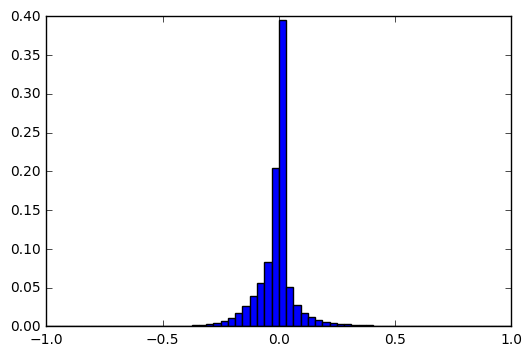

0.0
0.0
0.0
0.0
3.12499992106e-06
1.17187502724e-05
2.96875001595e-05


In [38]:
hist = np.histogram(scalars, bins = np.linspace(-1.0, 1.0, NBINS + 1))
sample_hist_probs = hist[0].astype('float32')
sample_hist_bins = hist[1].astype('float32')
sample_hist_probs /= np.sum(sample_hist_probs)

sample_hist_width = 1 * (sample_hist_bins[1] - sample_hist_bins[0])
sample_hist_centers = (sample_hist_bins[:-1] + sample_hist_bins[1:]) / 2
plt.bar(sample_hist_centers, sample_hist_probs, align='center', width=sample_hist_width)
plt.show()

if (NBINS > 9):
    for i in xrange(1, 8):
        p = 0
        for j in xrange(0, i):
            p += sample_hist_probs[j]
            p += sample_hist_probs[-j - 1]
        print p



In [39]:
[rate, data] = sciwav.read("./SA1.WAV")
data = data.astype(np.float32)
processedWave, wparams = preprocessWaveform(data)
windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed, tparams = preprocessWindows(windows)

transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
embed = aac_enc.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [40]:
idx = 56
print np.sqrt(np.sum(np.sort(np.square(embed[idx]))[-1:])) / np.linalg.norm(embed[idx])
print np.count_nonzero(embed[idx])
print embed[idx]

r = np.copy(embed)
threshold = 0
#r = np.sign(r)
qnt_bins = NBINS
#r[r < threshold] = -1.0
#r[r >= threshold] = 1.0
#r = np.round(r)
#r[(r < 0) & (r > -0.93)] = -0.936508
#r[(r > 0) & (r < 0.93)] = 0.936508
r = (r + 1.0) / 2.0
r = np.round(r * float(qnt_bins - 1))
qnt = r[idx].astype('int')
r /= float(qnt_bins - 1)
r = (r * 2.0) - 1.0
#r = np.sign(r)

print r[idx]
#print qnt



autoencOutput = aac_dec.predict(r, batch_size = BATCH_SIZE, verbose = 1)
print autoencOutput.shape
autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))

print autoencOutput.shape
recons = unpreprocessWindows(autoencOutput, tparams)

wav = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
wav = unpreprocessWaveform(wav, wparams)
wav = np.clip(wav, -32767.0, 32767.0)

sciwav.write("tst_output_reg.wav", rate, wav.astype(np.int16))

idx = 45

0.227223
128
[-0.042891 0.016404 0.111970 0.128005 0.155905 0.097488 0.062101 -0.027482
 -0.061657 -0.097623 -0.075259 -0.035517 0.021025 0.031701 0.021856
 -0.032786 -0.086593 -0.142016 -0.179433 -0.142458 -0.058207 0.020863
 0.083537 0.094474 0.088612 0.029143 -0.013464 -0.078252 -0.089416
 -0.098650 -0.038043 -0.009279 0.029006 0.010330 -0.017164 -0.075023
 -0.121070 -0.166712 -0.133399 -0.065924 0.009139 0.066015 0.086858
 0.085922 0.041043 0.003120 -0.054844 -0.077063 -0.081838 -0.045973
 -0.018948 0.009874 0.003805 -0.017530 -0.065717 -0.107681 -0.151343
 -0.106589 -0.058044 0.016970 0.053365 0.083608 0.073731 0.044744 0.003856
 -0.041281 -0.064828 -0.067376 -0.042340 -0.018171 0.000584 -0.002640
 -0.027380 -0.064478 -0.109799 -0.131944 -0.084579 -0.037305 0.028303
 0.055152 0.082882 0.063949 0.041992 -0.003117 -0.035450 -0.064967
 -0.064436 -0.032875 -0.008374 0.004690 -0.006659 -0.036243 -0.070182
 -0.117549 -0.127505 -0.085245 -0.032054 0.027584 0.058627 0.080907
 0.065720 0.0

In [41]:
b = np.linspace(-1.0, 1.0, NBINS + 1)
print b

h = np.histogram(scalars, bins = b)
print h[0]
print h[0].sum()
print h[1]
h = h[0].astype('float32')
h = h / h.sum()
print h

entropy = 0
for i in h:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print entropy

if (NBINS > 4):
    entropy = 0
    for idx in [0, 1, 2, -1, -2, -3]:
        i = h[idx]
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    print entropy

[-1.000000 -0.968750 -0.937500 -0.906250 -0.875000 -0.843750 -0.812500
 -0.781250 -0.750000 -0.718750 -0.687500 -0.656250 -0.625000 -0.593750
 -0.562500 -0.531250 -0.500000 -0.468750 -0.437500 -0.406250 -0.375000
 -0.343750 -0.312500 -0.281250 -0.250000 -0.218750 -0.187500 -0.156250
 -0.125000 -0.093750 -0.062500 -0.031250 0.000000 0.031250 0.062500
 0.093750 0.125000 0.156250 0.187500 0.218750 0.250000 0.281250 0.312500
 0.343750 0.375000 0.406250 0.437500 0.468750 0.500000 0.531250 0.562500
 0.593750 0.625000 0.656250 0.687500 0.718750 0.750000 0.781250 0.812500
 0.843750 0.875000 0.906250 0.937500 0.968750 1.000000]
[     0      0      0      0      0      1      1      0      6      6
     11     17     22     38     72    127    226    405    590    993
   1570   2522   3786   5819   9207  14523  22601  33741  50237  71804
 107200 261393 506085  64995  35826  22692  15517  11111   7985   6124
   4750   3625   2834   2286   1859   1513   1266    979    825    738
    556    457    